In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils.load import add_noise, load_data
from utils.params import set_param

warnings.filterwarnings("ignore")

sns.set_theme(style="ticks")
np.random.seed(42)

In [3]:
exp = "p4581"
params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, Y, t, dt, vl = load_data(exp, dirs, params)
Y = Y[:, 0:2]

In [4]:
df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[
        "det_shear_stress",
        "obs_shear_stress",
        "obs_normal_stress",
        "time",
    ],
)
df.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.002811,1.29911,2.99288,0.000
1,0.002731,1.29903,2.99008,0.001
2,0.002231,1.29853,2.98854,0.002
3,0.002411,1.29871,2.98849,0.003
4,0.002241,1.29854,2.99069,0.004


In [5]:
df = df.rolling(window=int(1e3), step=int(1e3)).mean().dropna()
df = df.reset_index(drop=True)

In [6]:
df.dropna()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.010441,1.306805,2.989703,0.500503
1,0.023812,1.320308,2.989567,1.500508
2,0.033829,1.330455,2.989649,2.500513
3,0.040971,1.337728,2.989704,3.500518
4,0.045985,1.342874,2.989764,4.500523
...,...,...,...,...
195,0.000035,1.321985,2.989949,195.501477
196,0.019188,1.341269,2.989867,196.501482
197,0.031596,1.353808,2.989849,197.501487
198,0.040136,1.362479,2.989979,198.501492


In [7]:
import statsmodels.api as sm

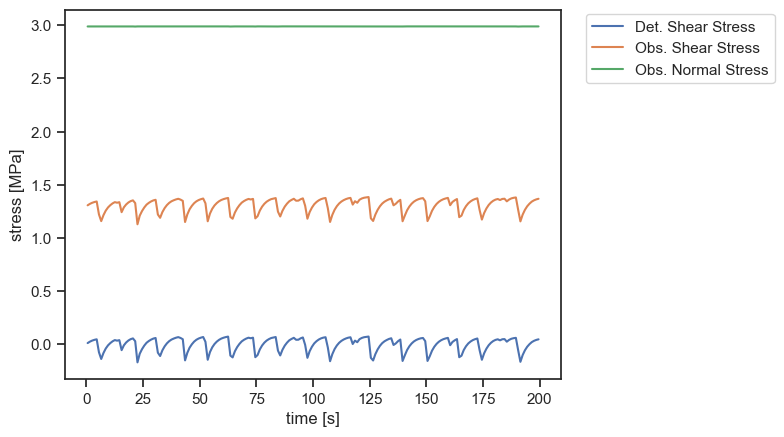

In [8]:
plt.plot(df["time"], df["det_shear_stress"], label="Det. Shear Stress")
plt.plot(df["time"], df["obs_shear_stress"], label="Obs. Shear Stress")
plt.plot(df["time"], df["obs_normal_stress"], label="Obs. Normal Stress")
plt.legend(loc=(1.05, 0.8))
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

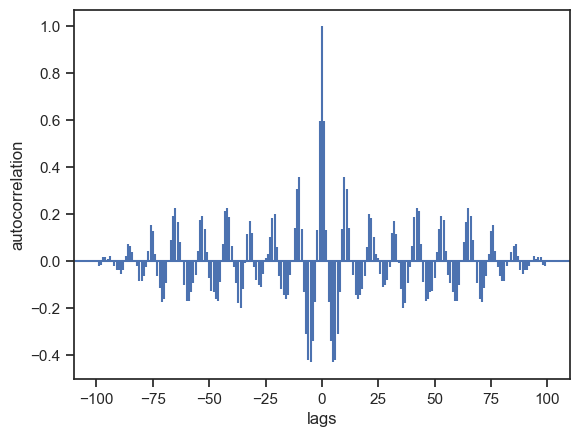

In [9]:
plt.acorr(df["det_shear_stress"], maxlags=100)[1][1]
plt.xlabel("lags")
plt.ylabel("autocorrelation")
plt.show();

In [10]:
RATIO = 0.80
LENGTH = df.shape[0]

train_data = df.iloc[: int(RATIO * LENGTH)]
test_data = df.iloc[int(RATIO * LENGTH) :]

In [11]:
import itertools

import joblib
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 10) for x in list(itertools.product(p, d, q))]


def objective_sarima(trial):
    length = len(train_data)
    train_data_obj = train_data["det_shear_stress"].iloc[: int(RATIO * length)]
    valid_data_obj = train_data["det_shear_stress"].iloc[int(RATIO * length) :]

    order = trial.suggest_categorical("order", pdq)
    seasonal_order = trial.suggest_categorical("seasonal_order", pdqs)
    trend = None
    model = SARIMAX(
        train_data_obj,
        order=order,
        seasonal_order=seasonal_order,
        trend=trend,
        initialization="approximate_diffuse",
    )
    model = model.fit(maxiter=250, disp=0)
    predictions = model.forecast(len(valid_data_obj))
    predictions = pd.Series(predictions, index=valid_data_obj.index)
    residuals = valid_data_obj.values - predictions.values
    mse = np.mean(residuals**2)
    return mse


if os.path.isfile("../models/p4581_detshearstress_rolling_sarima_study.pkl"):
    study = joblib.load(
        "../models/p4581_detshearstress_rolling_sarima_study.pkl"
    )
else:
    study = optuna.create_study()
    study.optimize(objective_sarima, n_trials=10, timeout=3600)
    joblib.dump(
        study, "../models/p4581_detshearstress_rolling_sarima_study.pkl"
    )

[I 2023-12-04 14:10:37,337] A new study created in memory with name: no-name-c54bda44-f9ca-40a2-92db-d87b67eff2a7
[I 2023-12-04 14:10:38,616] Trial 0 finished with value: 0.013639586427757276 and parameters: {'order': (2, 1, 1), 'seasonal_order': (2, 1, 1, 10)}. Best is trial 0 with value: 0.013639586427757276.
/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2023-12-04 14:10:42,405] Trial 1 finished with value: 1.5151955750346624 and parameters: {'order': (2, 2, 0), 'seasonal_order': (2, 2, 2, 10)}. Best is trial 0 with value: 0.013639586427757276.
[I 2023-12-04 14:10:43,159] Trial 2 finished with value: 0.04271330919759838 and parameters: {'order': (0, 1, 1), 'seasonal_order': (2, 0, 2, 10)}. Best is trial 0 with value: 0.013639586427757276.
[I 2023-12-04 14:10:43,779] Trial 3 fini

In [12]:
trial = study.best_trial
print("Accuracy: {}".format(trial.value))
print("Best params for SARIMAX: {}".format(trial.params))

Accuracy: 0.004996796383798281
Best params for SARIMAX: {'order': (1, 1, 2), 'seasonal_order': (2, 0, 2, 10)}


In [13]:
model = SARIMAX(
    train_data["det_shear_stress"],
    initialization="approximate_diffuse",
    **trial.params,
)

model = model.fit(maxiter=250, disp=0)

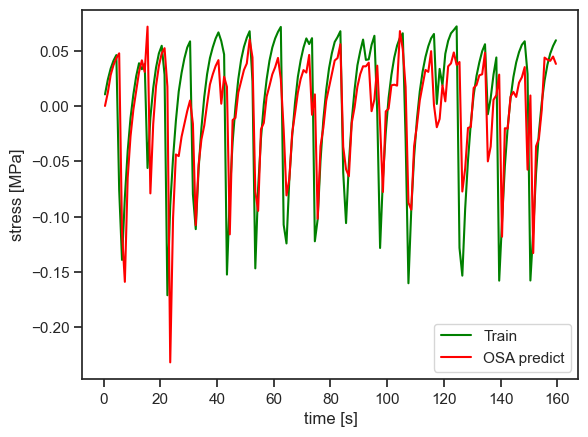

In [14]:
predict_train = model.predict(0, train_data["time"].shape[0])[:-1]

plt.plot(train_data["time"], train_data["det_shear_stress"], color="green")
plt.plot(train_data["time"], predict_train, color="red")
plt.legend(["Train", "OSA predict"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

print(
    f"Train R^2 Score:  {r2_score(predict_train, train_data['det_shear_stress']):.5f}"
)
print(
    f"Train RMSE Score: {np.sqrt(mean_squared_error(predict_train, train_data['det_shear_stress'])):.5f}"
)

Train R^2 Score:  -0.02259
Train RMSE Score: 0.04876


In [16]:
import copy
import pickle

from tqdm import tqdm


def perform_walkforward_validation(train_data, test_data, model):
    predictions = []
    for t in tqdm(range(len(test_data))):
        yhat = model.forecast()[0] if t != 0 else model.forecast().values[0]
        predictions.append(yhat)
        train_data = np.append(train_data, test_data[t : t + 1])
        model = SARIMAX(
            train_data,
            initialization="approximate_diffuse",
            **trial.params,
        )
        model = model.fit(maxiter=250, disp=0)
    return predictions


if os.path.isfile(
    f"{MAIN_DICT}/notebooks/models/p4581_detshearstress_sarima_rolling_study_wfv.pkl"
):
    with open(
        f"{MAIN_DICT}/notebooks/models/p4581_detshearstress_sarima_rolling_study_wfv.pkl",
        "rb",
    ) as handle:
        obj = pickle.load(handle)
        test_model, predict_test = obj["test_model"], obj["predict_test"]
else:
    test_model = copy.deepcopy(model)
    predict_test = perform_walkforward_validation(
        train_data["det_shear_stress"].values,
        test_data["det_shear_stress"].values,
        test_model,
    )
    with open(
        f"{MAIN_DICT}/notebooks/models/p4581_detshearstress_sarima_rolling_study_wfv.pkl",
        "wb",
    ) as handle:
        obj = {"test_model": test_model, "predict_test": predict_test}
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|███████████████████████████████████████████████| 40/40 [01:07<00:00,  1.68s/it]


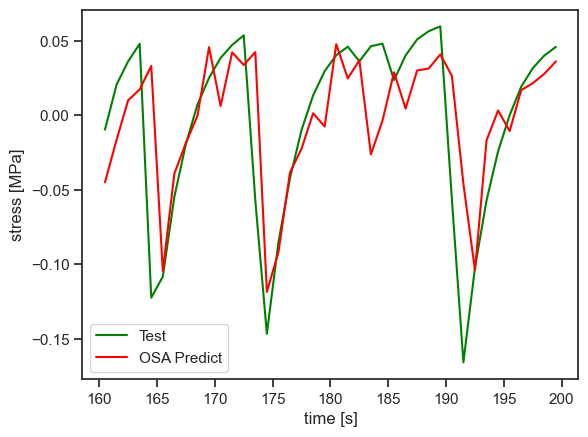

In [17]:
plt.plot(test_data["time"], test_data["det_shear_stress"], color="green")
plt.plot(test_data["time"], predict_test, color="red")
plt.legend(["Test", "OSA Predict"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

print(
    f"Test R^2 Score:  {r2_score(predict_test, test_data['det_shear_stress']):.5f}"
)
print(
    f"Test RMSE Score: {np.sqrt(mean_squared_error(predict_test, test_data['det_shear_stress'])):.5f}"
)

Test R^2 Score:  -0.05756
Test RMSE Score: 0.04424


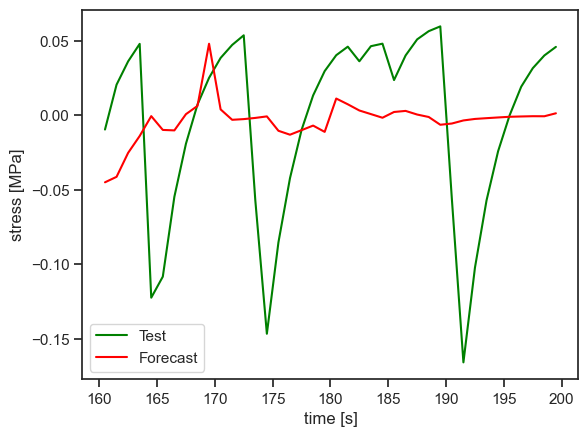

In [19]:
forecasts = model.forecast(len(test_data))
forecasts = pd.Series(forecasts, index=test_data.index)

plt.plot(test_data["time"], test_data["det_shear_stress"], color="green")
plt.plot(test_data["time"], forecasts, color="red")
plt.legend(["Test", "Forecast"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

print(
    f"Forecast R^2 Score:  {r2_score(forecasts, test_data['det_shear_stress']):.5f}"
)
print(
    f"Forecast RMSE Score: {np.sqrt(mean_squared_error(forecasts, test_data['det_shear_stress'])):.5f}"
)

Forecast R^2 Score:  -18.71081
Forecast RMSE Score: 0.06074
